In [1]:
import re
import json
import os
from types import SimpleNamespace

import torch
import torch.nn.functional as F

import numpy as np
#import ot
from pyitlib import discrete_random_variable as drv
from matplotlib import pyplot as plt
%matplotlib inline

from utils.solvers import FISTA
from model.lista import VIEncoderLISTA, LISTA
from model.vi_encoder import VIEncoder
from model.scheduler import CycleScheduler
from utils.dict_plotting import show_dict, show_phi_vid

[]

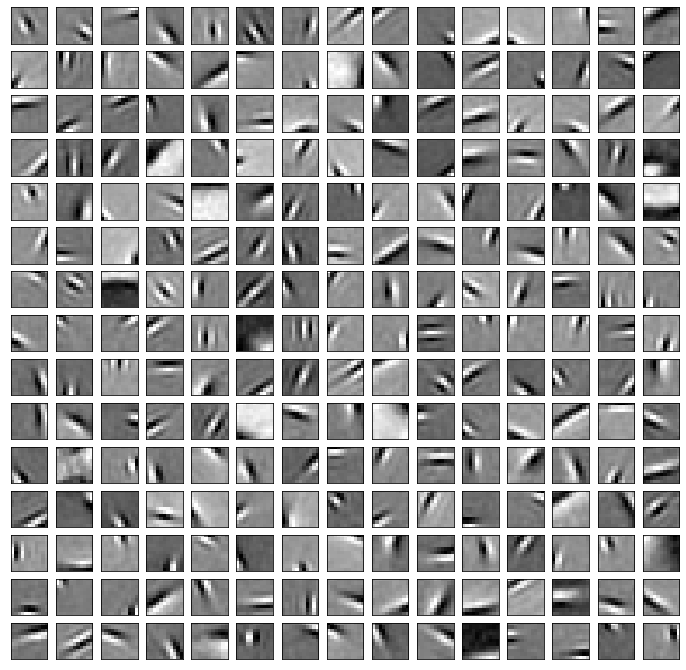

In [2]:
phi = np.load("data/mbedpatches_11.npz")['phi']

num_dictionaries = phi.shape[1]
patch_size = int(np.sqrt(phi.shape[0]))
fig = plt.figure(figsize=(12, 12))
for i in range(num_dictionaries):
    plt.subplot(int(np.sqrt(num_dictionaries)), int(np.sqrt(num_dictionaries)), i + 1)
    dict_element = phi[:, i].reshape(patch_size, patch_size)
    plt.imshow(dict_element, cmap='gray')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

In [3]:
code_count = 50000
real_images = True

if not real_images:
    true_support = 30
    random_codes = np.zeros((code_count, phi.shape[1]))
    support = np.random.randint(0, high=phi.shape[1], size=(code_count, true_support))
    for i in range(code_count):
        random_codes[i, support[i]] = np.random.randn(true_support)
    random_images = random_codes @ phi.T
else:
    data_file = f"data/imagepatches_11.np"
    if os.path.exists(data_file):
        with open(data_file, 'rb') as f:
            data_patches = np.load(f)
            val_patches = np.load(f)

    train_idx = np.linspace(1, data_patches.shape[0] - 1, code_count, dtype=int)
    train_patches = data_patches[train_idx, :, :].reshape(-1, 11**2)
    train_mean, train_std = np.mean(train_patches, axis=0), np.std(train_patches, axis=0)
    train_patches = (train_patches - train_mean) / train_std

    #random_codes = np.zeros((code_count, phi.shape[1]))
    #for i in range(code_count // 100):
    #    patches = random_images[i*100:(i+1)*100]
    #    random_codes[i*100:(i+1)*100] = FISTA(phi, patches.T, tau=solver_args.lambda_).T

In [4]:
coeff_eps = 1e-3
coeff_delta = 10e-2

base_run = 'results/concreteslab_1samp/'
load_list = ["10"]
#load_list = [int(re.search(r'epoch([0-9].*).pt', f)[1]) for f in os.listdir(base_run) if re.search(r'epoch([0-9].*).pt', f)]
#load_list = np.sort(load_list)

with open(base_run + "config.json") as json_data:
#with open("results/FISTA_normalize_v2/config.json") as json_data:
    config_data = json.load(json_data)
train_args = SimpleNamespace(**config_data['train'])
solver_args = SimpleNamespace(**config_data['solver'])

for idx, method in enumerate(load_list):
    np.random.seed(train_args.seed)
    torch.manual_seed(train_args.seed)
    multi_info = 0
    code_list = np.zeros((train_patches.shape[0], phi.shape[1]))
    kl_collapse = np.zeros(phi.shape[1])
    coeff_collapse = np.zeros(phi.shape[1])

    for i in range(train_patches.shape[0] // train_args.batch_size):
        patches = train_patches[i * train_args.batch_size:(i + 1) * train_args.batch_size].reshape(train_args.batch_size, -1).T

        if solver_args.solver == 'FISTA':
            code_est = FISTA(phi, patches, tau=solver_args.lambda_).T
            kl_loss = 1e99 * np.ones_like(code_est)
        else:
            with torch.no_grad():
                encoder = VIEncoder(train_args.patch_size, train_args.dict_size, solver_args).to('cuda:1')
                encoder.load_state_dict(torch.load(base_run + f"encoderstate_epoch{method}.pt")['model_state'])
                encoder.ramp_hyperparams()
                
                patches_cu = torch.tensor(patches.T).float().to('cuda:1')
                dict_cu = torch.tensor(phi, device='cuda:1').float()

                iwae_loss, recon_loss, kl_loss, b_cu = encoder(patches_cu, dict_cu)
                code_est = b_cu.detach().cpu().numpy()

        for k in range(phi.shape[1]):
            kl_collapse[k] += (kl_loss[:, k] <= 1e-2).sum()
            coeff_collapse[k] += (np.abs(code_est[:, k]) <= coeff_eps).sum()
        
        code_list[i*train_args.batch_size:(i+1)*train_args.batch_size] = code_est

    kl_collapse /= train_patches.shape[0]
    coeff_collapse /= train_patches.shape[0]
    percent_collapse = 100. * (kl_collapse >= 0.99).sum() / phi.shape[1]
    per_coeff_collapse = 100. * (coeff_collapse >= (1 - coeff_delta)).sum() / phi.shape[1]
    multi_info = drv.information_multi(code_list.T[:,:5000])
    print(f"{method}, multi-information: {multi_info:.3E}, % posterior collapse: {percent_collapse:.2f}%, % coeff collapse: {per_coeff_collapse:.2f}%")
    #print(f"Lambda: {encoder.lambda_.data}")
print()

10, multi-information: 1.159E+03, % posterior collapse: 73.78%, % coeff collapse: 73.78%



In [24]:
multi_info = drv.information_multi(code_list.T[:,:5000])
print(multi_info)

921.6674050979764


In [50]:
bins = np.linspace(-2, 2, 20)
bins = np.sort(np.append(bins, [-1e-50, 1e-50]))
alphabet = np.tile(np.arange(len(bins)+1), (code_list.shape[1], 1))
print(alphabet)
code = code_list.T[:,:5000]
code[0,0] = -1000

discrete_rv = np.digitize(code_list.T[:,:5000], bins)
print(discrete_rv[0, 0])
multi_info = drv.information_multi(discrete_rv, Alphabet_X=alphabet)
print(multi_info)

[[ 0  1  2 ... 20 21 22]
 [ 0  1  2 ... 20 21 22]
 [ 0  1  2 ... 20 21 22]
 ...
 [ 0  1  2 ... 20 21 22]
 [ 0  1  2 ... 20 21 22]
 [ 0  1  2 ... 20 21 22]]
0
333.9297284467672


In [50]:
from cuml.metrics.pairwise_distances import pairwise_distances
from scipy.special import gamma, psi

def estimate_entropy_knn(observations, k=4):
    n, d = observations.shape
    if d > 1:
        pairwise_dist = pairwise_distances(observations)
    else:
        pairwise_dist = np.abs(observations[:, None] - observations[None])  
        
    r_x = np.sort(pairwise_dist)[:, k]
    volume = (np.pi**(d/2)) / (gamma((d/2)+1))
    p_x = (k / (n - 1)) * (1 / volume) * (r_x ** -d)
    h_x = (-1 / n) * np.log(p_x).sum()
    h_x_corrected = h_x - (psi(k) - np.log(k))
    
    return h_x_corrected

marginal_entropy = 0
for i in range(code_list.shape[1]):
    samples = code_list[:5000, i, None]
    samples_non_neg = samples[np.nonzero(samples)[0]]
    zero_samp = len(samples) - len(np.nonzero(samples))
    zero_entropy = -(zero_samp/len(samples))*np.log(zero_samp/len(samples))
    if len(samples_non_neg) > 4:
        next_marg = estimate_entropy_knn(samples_non_neg, 4)
        if not np.isinf(next_marg):
            marginal_entropy += next_marg + zero_entropy
joint_entropy = estimate_entropy_knn(code_list[:5000], 4)

multi_info = marginal_entropy - joint_entropy
print(multi_info)

/tmp/ipykernel_2455103/4141786686.py:13: RuntimeWarning: divide by zero encountered in reciprocal
  p_x = (k / (n - 1)) * (1 / volume) * (r_x ** -d)


112.05738503700229


In [51]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

def estimate_entropy_kde(observations):
    params = {'bandwidth': np.logspace(-10, 10, 20)}
    gs = GridSearchCV(KernelDensity(kernel='exponential'), params)
    gs.fit(observations)
    kde = gs.best_estimator_
    log_p = kde.score_samples(observations) 
    p = np.exp(log_p)                
    entropy = -np.sum(p*log_p)
    return entropy
    
marginal_entropy = 0
for i in range(code_list.shape[1]):
    marginal_entropy += estimate_entropy_kde(code_list[:1000, i, None])
joint_entropy = estimate_entropy_kde(code_list[:1000])

multi_info = marginal_entropy - joint_entropy
print(multi_info)

3.8490011100693206e+51


In [ ]:
#base_run = "kl_results/VI_vampprior_kl1e-2/"
#epoch_load_list = ['0', '20', '40', '60', '100', '200', '299']
with open(base_run + "config.json") as json_data:
    config_data = json.load(json_data)
train_args = SimpleNamespace(**config_data['train'])
solver_args = SimpleNamespace(**config_data['solver'])

for idx, method in enumerate(epoch_load_list):
    encoder = VIEncoder(train_args.patch_size, train_args.dict_size, solver_args).to('cuda:1')
    encoder.load_state_dict(torch.load(base_run + f"encoderstate_epoch{method}.pt")['model_state'])

    pseudo_input = encoder.pseudo_inputs.data
    fig = plt.figure(figsize=(12, 12))
    for i in range(500):
        plt.subplot(23, 23, i + 1)
        dict_element = pseudo_input[i].detach().cpu().numpy().reshape(patch_size, patch_size)
        plt.imshow(dict_element, cmap='gray')
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

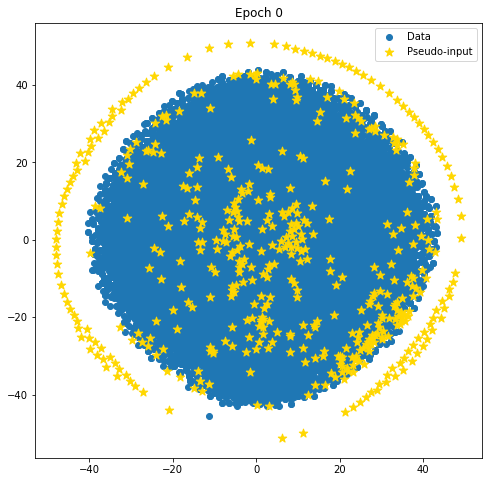

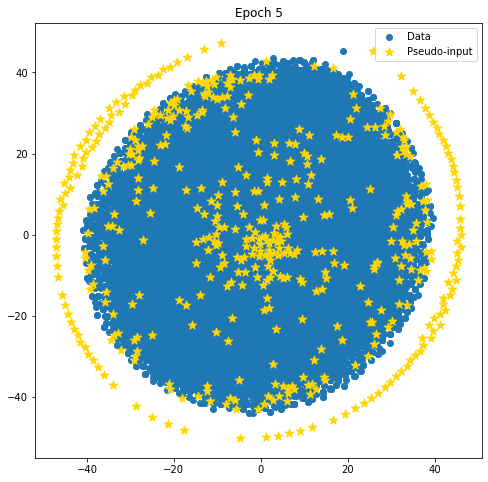

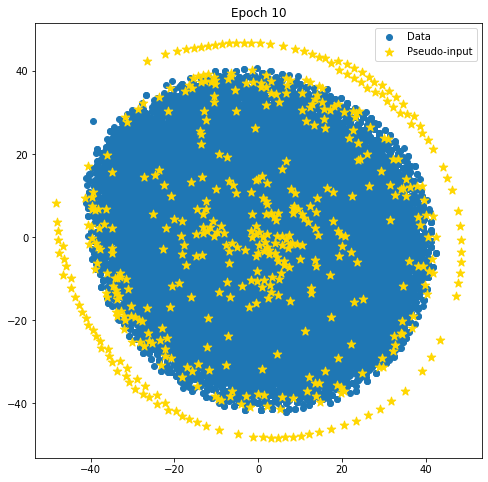

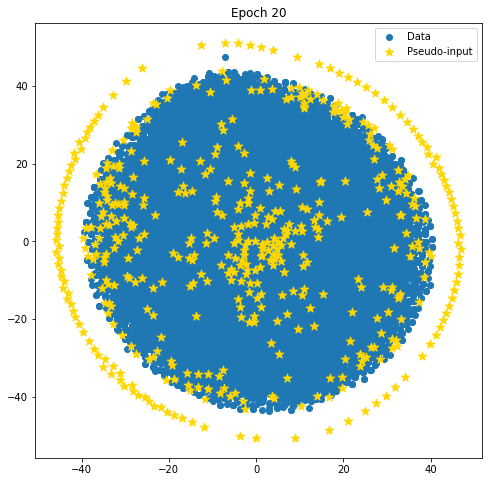

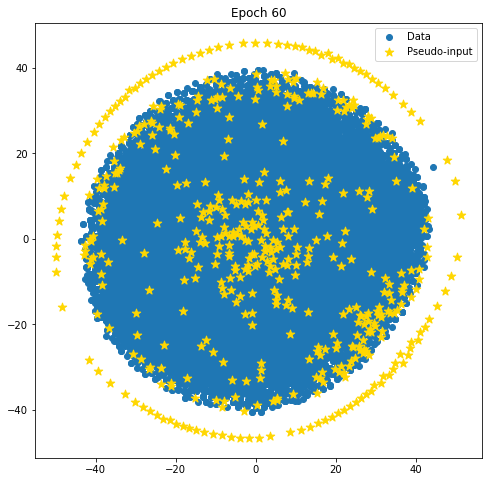

In [31]:
from sklearn.manifold import TSNE

code_count = 10000
real_images = True

if not real_images:
    true_support = 30
    random_codes = np.zeros((code_count, phi.shape[1]))
    support = np.random.randint(0, high=phi.shape[1], size=(code_count, true_support))
    for i in range(code_count):
        random_codes[i, support[i]] = np.random.randn(true_support)
    random_images = random_codes @ phi.T
else:
    data_file = f"data/imagepatches_16.np"
    if os.path.exists(data_file):
        with open(data_file, 'rb') as f:
            data_patches = np.load(f)
            val_patches = np.load(f)

    train_idx = np.linspace(1, data_patches.shape[0] - 1, code_count, dtype=int)
    random_images = data_patches[train_idx, :, :].reshape(-1, 16**2)
    random_images = random_images / np.linalg.norm(random_images, axis=1)[:, None]

base_run = "results/VI_vampprior_learnthresh_coadapt/"
epoch_load_list = ['0', '5', '10', '20', '100']
with open(base_run + "config.json") as json_data:
    config_data = json.load(json_data)
train_args = SimpleNamespace(**config_data['train'])
solver_args = SimpleNamespace(**config_data['solver'])

for idx, method in enumerate(epoch_load_list):
    encoder = VIEncoder(train_args.patch_size, train_args.dict_size, solver_args).to('cuda:1')
    encoder.load_state_dict(torch.load(base_run + f"encoderstate_epoch{method}.pt")['model_state'])
   
    pseudo_numpy = encoder.pseudo_inputs.data.detach().cpu().numpy()
    #pseudo_numpy /= np.linalg.norm(pseudo_numpy, axis=1)[..., None]
    embedd_patches = np.concatenate((pseudo_numpy, train_patches))
    X = TSNE(n_components=2).fit_transform(embedd_patches)

    plt.figure(figsize=(8,8))
    plt.title(f"Epoch {method}")
    plt.scatter(*X[500:].T, label="Data")
    plt.scatter(*X[:500].T, label="Pseudo-input", marker="*", color="gold", s=80)
    plt.legend()